In [16]:
import config
import src.data.ais_downloader as ais_downloader
import src.data.ais_filtering as ais_filtering
import src.data.ais_reader as ais_reader
import src.pre_proc.ais_segment as ais_segment

import src.data.ais_reader as ais_reader
import src.pre_proc.ais_query as ais_query 
import src.utils.ais_maps as ais_maps
import src.pre_proc.pre_processing_utils as pre_processing_utils

In [10]:
from tqdm import tqdm
from pathlib import Path
import pandas as pd
from datetime import date, timedelta

In [11]:
VERBOSE_MODE = True

START_DATE = "2025-05-21"  # Start date for data downloading
END_DATE   = "2025-05-21"  # End date for data downloading

AIS_DATA_NAME = config.AIS_DATA_FOLDER  # Name of the folder to store AIS data
DELETE_DOWNLOADED_CSV = False           # Whether to delete raw downloaded CSV files after processing

VESSEL_AIS_CLASS = ("Class A", "Class B") # AIS classes of vessels to include

MIN_SEGMENT_LENGTH = 30     # datapoints
MAX_TIME_GAP_SEC = 30       # seconds
MIN_TRACK_DURATION_SEC = 60 * 60 # seconds

REMOVE_ZERO_SOG_VESSELS = False # Whether to remove vessels with zero Speed Over Ground
SOG_IN_MS = True                # If True, SOG is in meters/second; if False, SOG is in knots
SOG_MIN_KNOTS = 0.5             # Minimum SOG in knots
SOG_MAX_KNOTS = 35.0            # Maximum SOG in knots

file_port_location = Path(config.AIS_DATA_FOLDER) / "port_locodes.csv"

# Bounding Box to prefilter AIS data [lat_max, lon_min, lat_min, lon_max]
BBOX = [57.58, 10.5, 57.12, 11.92]

# Polygon coordinates for precise Area of Interest (AOI) filtering (lon, lat)
POLYGON_COORDINATES = [
    (10.5162, 57.3500),  # coast top left (lon, lat)
    (10.9314, 57.5120),  # sea top left
    (11.5128, 57.5785),  # sea top right
    (11.9132, 57.5230),  # top right (Swedish coast)
    (11.9189, 57.4078),  # bottom right (Swedish coast)
    (11.2133, 57.1389),  # sea bottom right
    (11.0067, 57.1352),  # sea bottom left
    (10.5400, 57.1880),  # coast bottom left
    (10.5162, 57.3500),  # close polygon
]



# LEGGI UN CSV SINGOLO E FILTRALO

In [12]:
df_csv = ais_reader.read_raw_csv_with_filters(
    csv_name="aisdk-2025-05-21.csv",
    bbox=BBOX,
    time_start=None,
    time_end=None,
    csv_root="ais-data/csv",
    timestamp_format="%d/%m/%Y %H:%M:%S",
    polygon_coords=POLYGON_COORDINATES,
    verbose=True,
)
df_csv_filtered = ais_filtering.filter_ais_df(
    df_csv,
    polygon_coords=POLYGON_COORDINATES,
    allowed_mobile_types=VESSEL_AIS_CLASS,
    apply_polygon_filter=True,
    remove_zero_sog_vessels=REMOVE_ZERO_SOG_VESSELS,
    output_sog_in_ms=SOG_IN_MS,
    sog_min_knots=SOG_MIN_KNOTS,
    sog_max_knots=SOG_MAX_KNOTS,
    port_locodes_path= file_port_location,
    exclude_ports=True,     
    verbose=True,
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[read_raw_csv_with_filters] 513,285 rows, 207 vessels; no time filter applied
 [filter_ais_df] Before filtering: 513,285 rows, 207 vessels
 [filter_ais_df] Type filtering: 476,649 rows (removed 36,636) using ['Class A', 'Class B']
 [filter_ais_df] MMSI filtering: 476,646 rows, 205 vessels
 [filter_ais_df] Duplicate removal: 280,803 rows, 205 vessels
 [filter_ais_df] Polygon filtering: 280,803 rows (removed 0), 205 vessels
 [filter_ais_df] Port-area removal: removed 141,579 rows in 3 overlapping ports
 [filter_ais_df] COG sanity: 138,794 rows (removed 430) with range [0, 360] deg
 [filter_ais_df] SOG sanity: 135,420 rows (removed 3,374) with range [0.5, 35.0] knots
 [filter_ais_df] Final: 135,420 rows, 180 unique vessels (SOG in m/s)


# LEGGI TUTTI GIA I BELLINI DAL PARQUET

In [78]:
parquet_folder_path = Path(config.AIS_DATA_FOLDER) / "parquet"

In [80]:
df_parquet = ais_query.query_ais_duckdb(parquet_folder_path, verbose=True)
        

[ais_query] Querying parquet files from: ais-data\parquet  from date None  to date  None


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[ais_query] 1,352,475 rows, 976 vessels, from date None to date None


# preprocessa

In [81]:
df = df_parquet.copy()
# Dropping unnecessary columns and rows with missing values
print(f"[pre_processing] Initial data size: {len(df)} records.")
print(f"[pre_processing] Dropping unnecessary columns and rows with missing values...")
df.drop(columns=[ 
    'Type of mobile', 
    'ROT', 
    'Heading', 
    'IMO', 
    'Callsign', 
    'Name', 
    'Navigational status',
    'Cargo type', 
    'Width', 
    'Length',
    'Type of position fixing device', 
    'Draught', 
    'Destination', 
    'ETA',
    'Data source type', 
    'A', 'B', 'C', 'D', 
    'Date'], inplace=True, errors='ignore')

df.dropna(inplace=True)
print(f"[pre_processing] Data size after dropping: {len(df)} records.")

[pre_processing] Initial data size: 1352475 records.
[pre_processing] Dropping unnecessary columns and rows with missing values...
[pre_processing] Data size after dropping: 1352475 records.


# decide i parametri segmentazione

In [82]:
MIN_POINTS = 10
MIN_TRACK_DURATION_SEC = 10*60  # 10 min
MAX_TIME_GAP_SEC = 60*15     

FREQ_POINT = 1

In [83]:
df_segmented = ais_segment.segment_ais_tracks(
                df,
                min_track_len = MIN_POINTS,   # datapoints    
                min_track_duration_sec = MIN_TRACK_DURATION_SEC, # 10 minutes
                max_time_gap_sec = MAX_TIME_GAP_SEC,       
                verbose = True
            )

[segment_ais_tracks] Starting with 1,352,475 rows, 976 unique vessels
[segment_ais_tracks] After segment-level filter: 1,350,700 rows, 1,695 segments


In [84]:
df_segmented = pre_processing_utils.add_segment_nr(df_segmented)

In [85]:

print(f"\nStatistics for segmentation with max time gap {MAX_TIME_GAP_SEC/60}min , min duration {MIN_TRACK_DURATION_SEC/60}min, min freq point {FREQ_POINT} points/min:")
# Count unique Segment_uid values and show top segments by frequency
unique_count = df_segmented['Segment_nr'].nunique()
print(f"Unique Segment_nr count: {unique_count}")

unique_vess = df_segmented['MMSI'].nunique()
print(f"Unique Vessel MMSI count: {unique_vess}")

mmsi_multi = df_segmented.groupby('MMSI')['Segment_nr'].nunique().loc[lambda x: x > 1].sort_values(ascending=False)
print(f"MMSI with more than one segment: {len(mmsi_multi)}")
# Build per-segment stats
segment_stats = (
    df_segmented.groupby('Segment_nr')
      .agg(n_points=('Timestamp', 'size'),
           t_min=('Timestamp', 'min'),
           t_max=('Timestamp', 'max'))
      .reset_index()
)
segment_stats['duration'] = segment_stats['t_max'] - segment_stats['t_min']
segment_stats = segment_stats.sort_values('n_points', ascending=False)

segment_stats['freq_point'] = segment_stats['n_points'] / segment_stats['duration'].dt.total_seconds() *60
# Apply filter freq >= 1 points/min

eligible = segment_stats.loc[
    (segment_stats['freq_point'] >= FREQ_POINT),
    'Segment_nr'
]

# Filter the dataframe
before = len(df_segmented)
df_segmented = df_segmented[df_segmented['Segment_nr'].isin(eligible)].copy()
after = len(df_segmented)
removed_segments = segment_stats['Segment_nr'].nunique() - eligible.nunique()
removed_perc = removed_segments / segment_stats['Segment_nr'].nunique() * 100
print(f"Kept segments: {eligible.nunique()} | Removed segments: {removed_segments} | Removed perc: {removed_perc:.2f}% | Rows: {before} -> {after}")



Statistics for segmentation with max time gap 15.0min , min duration 10.0min, min freq point 1 points/min:
Unique Segment_nr count: 1797
Unique Vessel MMSI count: 969
MMSI with more than one segment: 334
Kept segments: 1776 | Removed segments: 21 | Removed perc: 1.17% | Rows: 1350700 -> 1349471


In [86]:
# take the removed segments  in a df magari mi servono dopo

df_removed = df_segmented[~df_segmented['Segment_nr'].isin(eligible)].copy()

In [2]:
import seaborn as sns
import numpy as np
from matplotlib.colors import LogNorm

import matplotlib.pyplot as plt


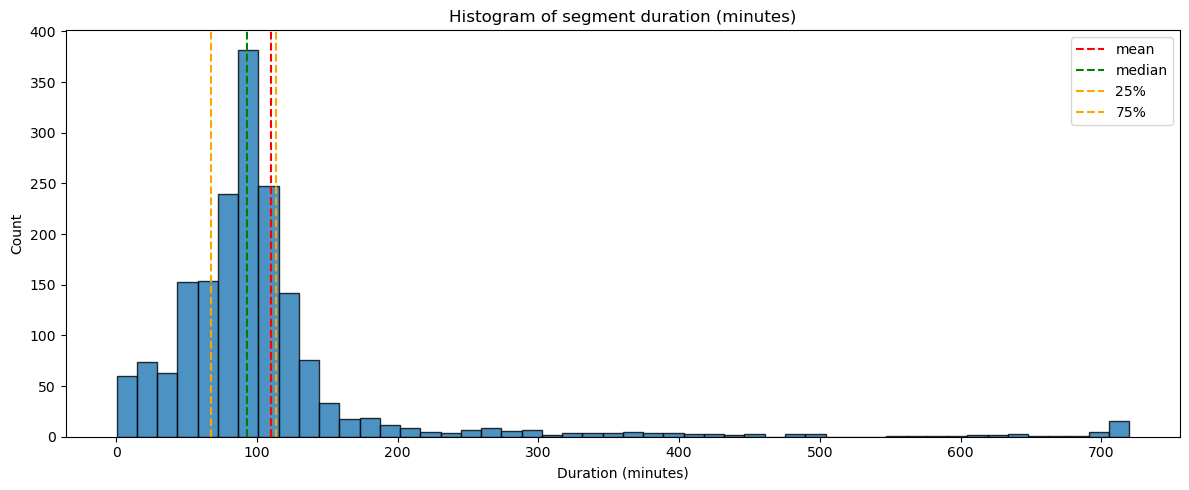

Duration (minutes) statistics:
count: 1797
min:   0.28
25%:   67.32
median:92.83
75%:   113.65
90%:   155.58
95%:   277.57
max:   719.98
mean:  110.21
std:   103.07


In [88]:
# Histogram with summary stats for segment durations (in minutes)
dur_minutes = segment_stats['duration'].dt.total_seconds() / 60

fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(dur_minutes, bins=50, color='C0', edgecolor='k', alpha=0.8)
ax.set_xlabel('Duration (minutes)')
ax.set_ylabel('Count')
ax.set_title('Histogram of segment duration (minutes)')

# Compute stats
stats = dur_minutes.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])
mean_v = dur_minutes.mean()
median_v = dur_minutes.median()
p25, p75 = stats['25%'], stats['75%']

# Add reference lines
for val, label, color in [
    (mean_v, 'mean', 'red'),
    (median_v, 'median', 'green'),
    (p25, '25%', 'orange'),
    (p75, '75%', 'orange'),
]:
    ax.axvline(val, color=color, linestyle='--', linewidth=1.5, label=label)

ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Print summary statistics
print("Duration (minutes) statistics:")
print(f"count: {int(stats['count'])}")
print(f"min:   {stats['min']:.2f}")
print(f"25%:   {stats['25%']:.2f}")
print(f"median:{stats['50%']:.2f}")
print(f"75%:   {stats['75%']:.2f}")
print(f"90%:   {stats['90%']:.2f}")
print(f"95%:   {stats['95%']:.2f}")
print(f"max:   {stats['max']:.2f}")
print(f"mean:  {mean_v:.2f}")
print(f"std:   {stats['std']:.2f}")

In [53]:
from src.utils.ais_maps import create_all_ships_paths_html

In [54]:
m = create_all_ships_paths_html(df_removed)

Found 26 MMSIs in the DataFrame.
Map with all ships saved to: all_ships_map.html


In [58]:
m2 = ais_maps.create_ship_path_html(df_removed, 219024585, 'removed.html', n_points=500)

Map saved to: removed.html
